In [3]:
import os
import re

# ------------------------------
# 可接受的参数列表（来自你的 .sh）
# ------------------------------
VALID_RATIO_DYN = {"0.00", "0.30", "0.70", "0.90", "0.95", "0.99"}
VALID_N_DYNBR = {4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048}
VALID_N_DYNBR_V = {4, 8, 16, 32, 64}


def parse_filename_params(filename):
    """
    解析文件名中的参数：ratio_dyn, N_dynbr, N_dynbr_v
    文件名格式示例：
        ratio0.30_t64_v512.log
    """
    reg = re.compile(
        r"ratio(?P<ratio>[0-9.]+)_t(?P<t>[0-9]+)_v(?P<v>[0-9]+)\.log"
    )
    m = reg.search(filename)
    if not m:
        return None, None, None

    ratio_dyn = m.group("ratio")
    N_dynbr = int(m.group("t"))
    N_dynbr_v = int(m.group("v"))
    return ratio_dyn, N_dynbr, N_dynbr_v


def check_from_sh(ratio_dyn, N_dynbr, N_dynbr_v):
    """
    判断该 (ratio_dyn, N_dynbr, N_dynbr_v) 是否符合 .sh 的遍历。
    """
    if ratio_dyn not in VALID_RATIO_DYN:
        return False
    if N_dynbr not in VALID_N_DYNBR:
        return False
    if N_dynbr_v not in VALID_N_DYNBR_V:
        return False
    return True


def parse_log_file(path, filename):
    """
    解析单个日志文件内容，返回一个 dict。
    """

    max_valid_acc = None
    min_valid_loss = None

    pct00 = pct01 = pct10 = pct11 = None  # 4 个 percentage

    # 正则表达式
    reg_valid_loss = re.compile(r"valid loss:\s*([0-9.]+)")
    reg_valid_acc  = re.compile(r"valid acc:\s*([0-9.]+)")

    # percentage 表
    reg_pct_row = re.compile(
        r"\|\s*(现在对了|现在错了)\s*\|\s*([0-9.]+)%\s*\|\s*([0-9.]+)%\s*\|"
    )

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            # valid loss
            m = reg_valid_loss.search(line)
            if m:
                v = float(m.group(1))
                if min_valid_loss is None or v < min_valid_loss:
                    min_valid_loss = v

            # valid acc
            m = reg_valid_acc.search(line)
            if m:
                v = float(m.group(1))
                if max_valid_acc is None or v > max_valid_acc:
                    max_valid_acc = v

            # table percentage
            m = reg_pct_row.search(line)
            if m:
                typ = m.group(1)
                v1 = float(m.group(2))
                v2 = float(m.group(3))
                if typ == "现在对了":
                    pct00 = v1
                    pct01 = v2
                else:
                    pct10 = v1
                    pct11 = v2

    # 解析文件名参数
    ratio_dyn, N_dynbr, N_dynbr_v = parse_filename_params(filename)

    return {
        "file": filename,
        "ratio_dyn": ratio_dyn,
        "N_dynbr": N_dynbr,
        "N_dynbr_v": N_dynbr_v,
        "valid_from_sh": check_from_sh(ratio_dyn, N_dynbr, N_dynbr_v),
        "max_valid_acc": max_valid_acc,
        "min_valid_loss": min_valid_loss,
        "pct_now_correct_old_correct": pct00,
        "pct_now_correct_old_wrong": pct01,
        "pct_now_wrong_old_correct": pct10,
        "pct_now_wrong_old_wrong": pct11,
    }


def collect_all_logs(root="."):
    """
    遍历 root 下所有 .log 文件，对每个调用 parse_log_file。
    """
    results = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".log"):
                full = os.path.join(dirpath, fn)
                res = parse_log_file(full, fn)
                results.append(res)
    return results


# ------------------------- 主入口 -------------------------
if __name__ == "__main__":
    logs = collect_all_logs(".")
    print(f"解析到日志文件数：{len(logs)}\n")

    for item in logs:
        print(item)


解析到日志文件数：601

{'file': 'ratio0.95_t256_v2048.log', 'ratio_dyn': '0.95', 'N_dynbr': 256, 'N_dynbr_v': 2048, 'valid_from_sh': False, 'max_valid_acc': 0.5117, 'min_valid_loss': 2.24106, 'pct_now_correct_old_correct': 45.85, 'pct_now_correct_old_wrong': 5.08, 'pct_now_wrong_old_correct': 12.01, 'pct_now_wrong_old_wrong': 37.06}
{'file': 'ratio0.95_t32_v4.log', 'ratio_dyn': '0.95', 'N_dynbr': 32, 'N_dynbr_v': 4, 'valid_from_sh': True, 'max_valid_acc': 0.498, 'min_valid_loss': 2.70614, 'pct_now_correct_old_correct': 44.63, 'pct_now_correct_old_wrong': 4.3, 'pct_now_wrong_old_correct': 13.23, 'pct_now_wrong_old_wrong': 37.84}
{'file': 'ratio0.90_t2048_v4.log', 'ratio_dyn': '0.90', 'N_dynbr': 2048, 'N_dynbr_v': 4, 'valid_from_sh': True, 'max_valid_acc': 0.5117, 'min_valid_loss': 2.606578, 'pct_now_correct_old_correct': 46.0, 'pct_now_correct_old_wrong': 4.05, 'pct_now_wrong_old_correct': 11.87, 'pct_now_wrong_old_wrong': 38.09}
{'file': 'ratio0.99_t4_v4.log', 'ratio_dyn': '0.99', 'N_dynbr': 4,

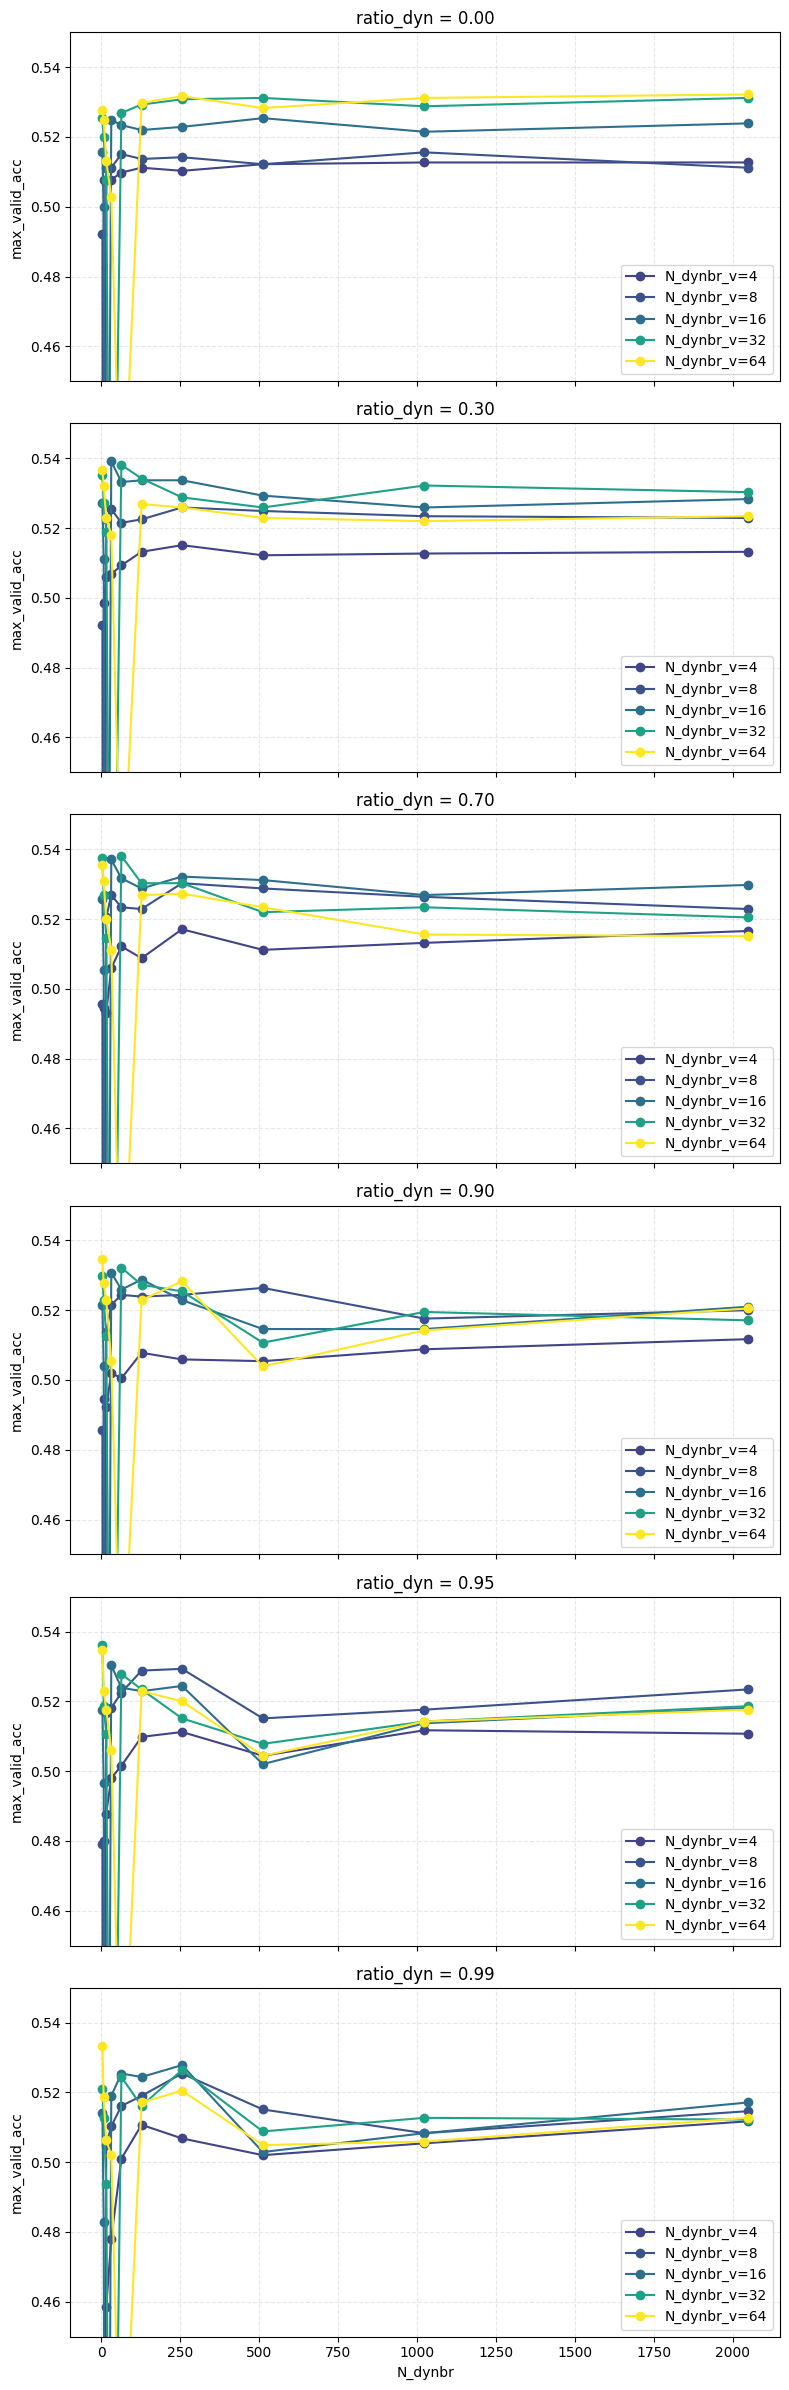

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 将 logs 列表按 ratio_dyn 分组
# -------------------------
groups = {}
for item in logs:
    if not item["valid_from_sh"]:
        continue
    r = item["ratio_dyn"]
    groups.setdefault(r, []).append(item)

# 排序 ratio_dyn
ratio_list = sorted(groups.keys(), key=float)

# 定义色系
cmap = plt.get_cmap("viridis")  # 可换 "Oranges", "Purples", "Greens" 等

# N_dynbr_v 的范围（用于颜色深浅映射）
all_v = sorted({item["N_dynbr_v"] for item in logs if item["valid_from_sh"]})
v_min, v_max = min(all_v), max(all_v)

def v_to_color(v):
    """N_dynbr_v 越大颜色越深；归一化后映射到 cmap"""
    alpha = 0.2 + 0.8 * (v - v_min) / (v_max - v_min + 1e-8)
    return cmap(alpha)

# -------------------------
# 开始绘图
# -------------------------
fig, axes = plt.subplots(len(ratio_list), 1, figsize=(8, 4 * len(ratio_list)), sharex=True)

if len(ratio_list) == 1:
    axes = [axes]

for ax, r in zip(axes, ratio_list):
    data = groups[r]

    # 收集 N_dynbr_v 分组
    v_groups = {}
    for item in data:
        v = item["N_dynbr_v"]
        v_groups.setdefault(v, []).append(item)

    # 每条曲线是一个 N_dynbr_v
    for v in sorted(v_groups.keys()):
        sub = v_groups[v]
        # 按 N_dynbr 排序
        sub = sorted(sub, key=lambda x: x["N_dynbr"])

        xs = [x["N_dynbr"] for x in sub]
        ys = [x["max_valid_acc"] for x in sub]

        ax.plot(xs, ys, marker="o", color=v_to_color(v), label=f"N_dynbr_v={v}")

    ax.set_title(f"ratio_dyn = {r}")
    ax.set_ylabel("max_valid_acc")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend()
    ax.set_ylim(0.45, 0.55)

axes[-1].set_xlabel("N_dynbr")

plt.tight_layout()
plt.show()


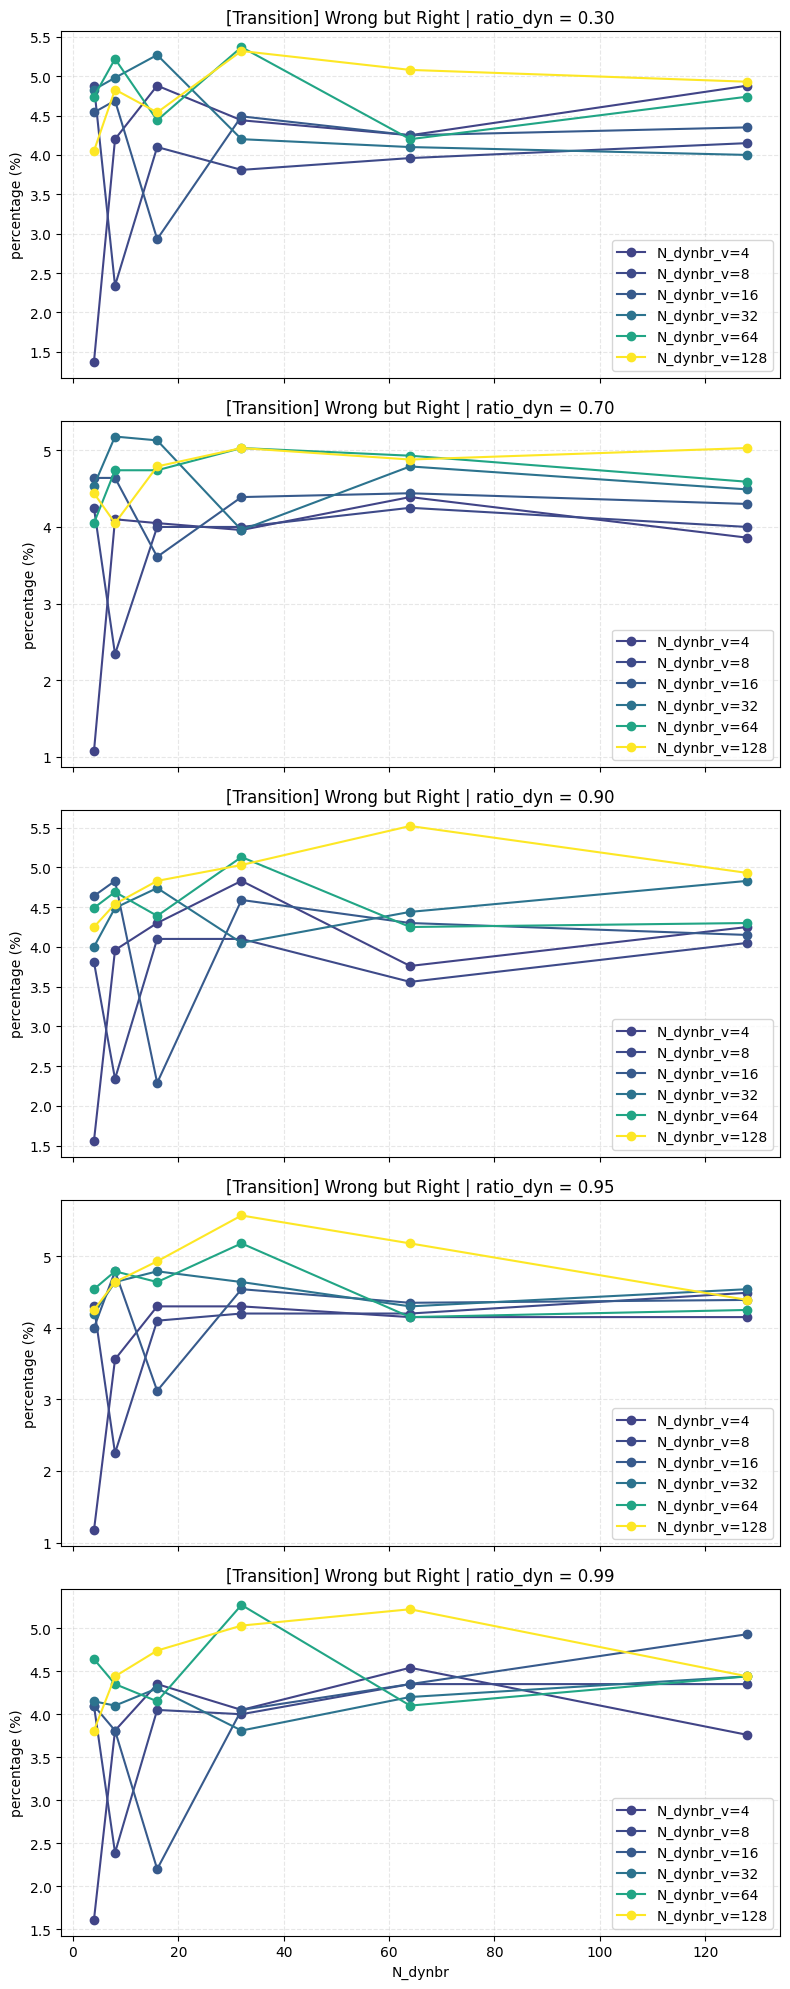

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 复用前面定义的 groups, ratio_list, v_to_color, etc.

fig, axes = plt.subplots(len(ratio_list), 1, figsize=(8, 4 * len(ratio_list)), sharex=True)

if len(ratio_list) == 1:
    axes = [axes]

for ax, r in zip(axes, ratio_list):
    data = groups[r]

    # 按 N_dynbr_v 分组
    v_groups = {}
    for item in data:
        v = item["N_dynbr_v"]
        v_groups.setdefault(v, []).append(item)

    # 每条曲线是一个 N_dynbr_v
    for v in sorted(v_groups.keys()):
        sub = v_groups[v]
        # 按 N_dynbr 排序
        sub = sorted(sub, key=lambda x: x["N_dynbr"])

        xs = [x["N_dynbr"] for x in sub]

        # ★ 纵轴改为 “原来错的，现在对的” 比例 ★
        ys = [x["pct_now_correct_old_wrong"] for x in sub]

        ax.plot(xs, ys, marker="o", color=v_to_color(v), label=f"N_dynbr_v={v}")

    ax.set_title(f"[Transition] Wrong but Right | ratio_dyn = {r}")
    ax.set_ylabel("percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("N_dynbr")

plt.tight_layout()
plt.show()
